##                                         Predição de Demanda



##### Dataset Fornecido

https://s3.amazonaws.com/big-data-public/desafio/desafio.csv.gz

In [2]:
# Libraries for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcdefaults()

In [3]:
# load data
df = pd.read_csv('desafio.csv')

In [4]:
df.info()# +-180K lines

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179149 entries, 0 to 179148
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          179149 non-null  object 
 1   code              179149 non-null  object 
 2   quantity          179149 non-null  int64  
 3   price             179149 non-null  float64
 4   pis_cofins        179149 non-null  float64
 5   icms              179149 non-null  float64
 6   tax_substitution  179149 non-null  float64
 7   category          179149 non-null  object 
 8   liquid_cost       179149 non-null  float64
 9   order_status      179149 non-null  object 
 10  capture_date      179149 non-null  object 
 11  process_date      179149 non-null  object 
 12  process_status    179149 non-null  object 
 13  source_channel    179149 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 19.1+ MB


In [5]:
df.head(2)

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500


In [6]:
# simplify hash names 
df['category'] = df['category'].map(lambda x: x[-3:])
df['source_channel'] = df['source_channel'].map(lambda x: x[-3:])
df['code'] = df['code'].map(lambda x: x[-3:])

In [7]:
#How many categories do we have
df_category_dist = df.category.unique()
df_category_dist.shape

(11,)

In [8]:
#What proportion between them
df.category.value_counts(normalize=True)
#The 64b final category represents 86% of the dataset, that's a huge bias!!!

64b    0.859301
b99    0.100525
a66    0.029071
290    0.005878
5ed    0.001842
29a    0.001116
a51    0.000781
c4f    0.000407
200    0.000396
31b    0.000357
eda    0.000324
Name: category, dtype: float64

In [9]:
# source_channel x category
myCrosstable = pd.crosstab(df['source_channel'], df['category'])
myCrosstable

category,200,290,29a,31b,5ed,64b,a51,a66,b99,c4f,eda
source_channel,,,,,,,,,,,
002,14,188,2,7,21,14839,0,467,2170,2,4
121,0,0,0,0,0,2,0,0,0,0,0
262,0,4,0,0,0,714,0,44,63,0,1
3a7,0,46,0,0,0,2808,0,55,274,0,0
500,35,352,4,35,80,67724,0,3097,10467,19,24
5ee,5,127,0,1,0,3762,0,110,572,2,0
601,1,48,191,8,118,29500,139,421,766,33,14
7a8,2,15,0,2,14,6914,0,59,245,0,0
8f7,0,0,0,0,0,1,0,0,0,0,0


In [10]:
#How many Products do we have
df_prod_dist = df.code.unique()
df_prod_dist.shape

(131,)

In [11]:
# Product x Quantity
df.quantity.value_counts(normalize=True)
#We see that 97% of product sales is only ONE quantity, maybe another bias.

1      0.970416
2      0.020687
5      0.003416
3      0.003394
4      0.001306
10     0.000262
6      0.000134
8      0.000067
20     0.000050
7      0.000050
15     0.000033
16     0.000028
18     0.000017
24     0.000011
13     0.000011
9      0.000011
12     0.000011
30     0.000011
27     0.000006
29     0.000006
14     0.000006
17     0.000006
70     0.000006
21     0.000006
25     0.000006
34     0.000006
38     0.000006
40     0.000006
45     0.000006
48     0.000006
50     0.000006
60     0.000006
100    0.000006
Name: quantity, dtype: float64

In [12]:
# Outliers - Price
df_price_quantity = df[['quantity','price']].sort_values(by='price',ascending = False)
df_price_quantity.head(10)

,quantity,price
173361,70,19993.00
33602,48,19152.00
131270,100,16140.00
172788,50,15470.00
147000,16,11420.96
146999,16,11420.96
172195,30,8355.00
119949,45,8095.51
146270,12,7950.00
156772,38,7782.40


In [13]:
## Analyzing the Status
df['process_status'].value_counts()

processado    154443
captado        24706
Name: process_status, dtype: int64

In [14]:
## Captured or processed sales matter?
df_status = df[['order_status','process_status']]
df_status = df_status[df_status['process_status']=='captado']
df_status.order_status.unique()

array(['cancelado', 'cancelado boleto não pago', 'suspenso barragem',
       'cancelado dados divergentes', 'fraude confirmada',
       'cancelado fraude confirmada', 'suspeita de fraude',
       'em rota de devolução', 'pendente processamento',
       'cancelado não aprovado'], dtype=object)

In [15]:
# Get just sucessfull sales - 154K lines 
df = df[df['process_status'] == 'processado']
df.info()# 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154443 entries, 0 to 179148
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          154443 non-null  object 
 1   code              154443 non-null  object 
 2   quantity          154443 non-null  int64  
 3   price             154443 non-null  float64
 4   pis_cofins        154443 non-null  float64
 5   icms              154443 non-null  float64
 6   tax_substitution  154443 non-null  float64
 7   category          154443 non-null  object 
 8   liquid_cost       154443 non-null  float64
 9   order_status      154443 non-null  object 
 10  capture_date      154443 non-null  object 
 11  process_date      154443 non-null  object 
 12  process_status    154443 non-null  object 
 13  source_channel    154443 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 17.7+ MB


In [16]:
# delete columns
columns_to_delete = [
    "order_id",
    "order_status",
    "capture_date",
    "process_status",
]
df.drop(columns_to_delete, 1, inplace=True)

In [17]:
# transform datetime
df = df[df['process_date']!='0000-00-00']
df['process_date'] = pd.to_datetime(df['process_date'], infer_datetime_format=True)

In [18]:
# Remove the category 64b
df = df[df['category'] !='64b']

In [19]:
# 10 categories
df1 = df.category.unique()
df1.shape

(10,)

In [20]:
df.head(10)

,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,process_date,source_channel
0,ad5,1,978.90,90.5483,0.0000,191.8416,31b,542.7065,2016-06-11,500
1,ad5,1,1036.29,95.8568,176.1693,0.0000,31b,542.7065,2016-06-11,500
2,ad5,1,978.90,90.5483,0.0000,191.8416,31b,542.7065,2016-06-12,500
4,ad5,1,976.05,90.2846,0.0000,192.3325,31b,542.7065,2016-06-13,500
5,ad5,1,1089.10,100.7418,185.1470,0.0000,31b,542.7065,2016-06-13,002
6,ad5,1,949.00,87.7825,170.8200,0.0000,31b,542.7065,2016-06-14,5ee
9,ad5,1,949.00,87.7825,170.8200,0.0000,31b,542.7065,2016-09-27,f58
11,ad5,1,949.00,87.7825,161.3300,0.0000,31b,542.7065,2016-10-04,d3a
12,ad5,1,901.55,83.3934,0.0000,191.3848,31b,542.7065,2016-10-05,002
13,ad5,1,978.90,90.5483,0.0000,192.1183,31b,542.7065,2016-10-08,500


### Some Analysis

In [21]:
#Important information for marketing team. Source channel 500 (app,site) 
myCrosstable = pd.crosstab(df['source_channel'], df['code'])
myCrosstable

code,02a,094,0f6,1f1,29e,2a0,2b5,2fb,31d,4e5,...,ac5,ad5,bda,c8c,cb3,cd1,ddf,e21,e57,fab
source_channel,,,,,,,,,,,,,,,,,,,,,
002,2,0,0,63,0,82,34,67,10,0,...,126,6,5,2,61,1600,0,19,51,10
262,1,0,0,7,0,4,6,6,0,0,...,4,0,1,0,10,53,0,2,6,0
3a7,0,0,0,6,0,9,3,24,0,0,...,38,0,0,0,0,216,0,3,2,0
500,22,1,2,615,9,294,196,447,33,0,...,306,27,30,16,590,8920,0,204,507,28
5ee,0,0,0,7,0,17,3,11,0,0,...,98,1,2,1,14,412,0,8,31,3
601,14,7,0,113,9,20,16,37,77,3,...,45,1,7,22,124,730,7,34,42,1
7a8,0,0,0,13,1,12,6,3,6,0,...,13,2,1,0,14,184,0,7,3,2
8f9,2,0,0,24,1,7,8,8,7,0,...,26,0,0,3,13,252,0,8,4,0
bb9,1,0,0,14,0,40,5,9,0,0,...,6,0,0,0,1,517,0,7,1,2


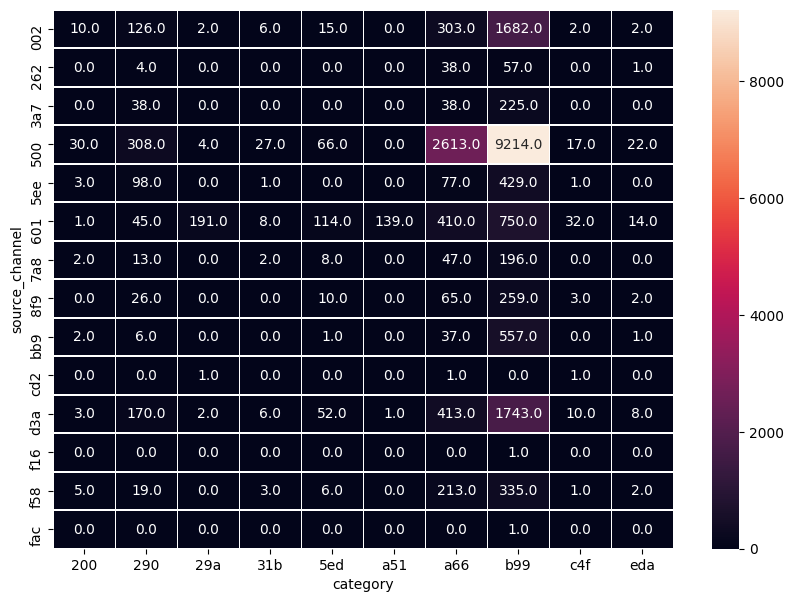

In [22]:
# Source Channel x Category 
myCrosstable2 = pd.crosstab(df['source_channel'], df['category'])

plt.rcdefaults()
plt.figure(figsize=(10,7))
ax = sns.heatmap(myCrosstable2, linewidths=.5,  annot=True, fmt=".1f")
plt.show()

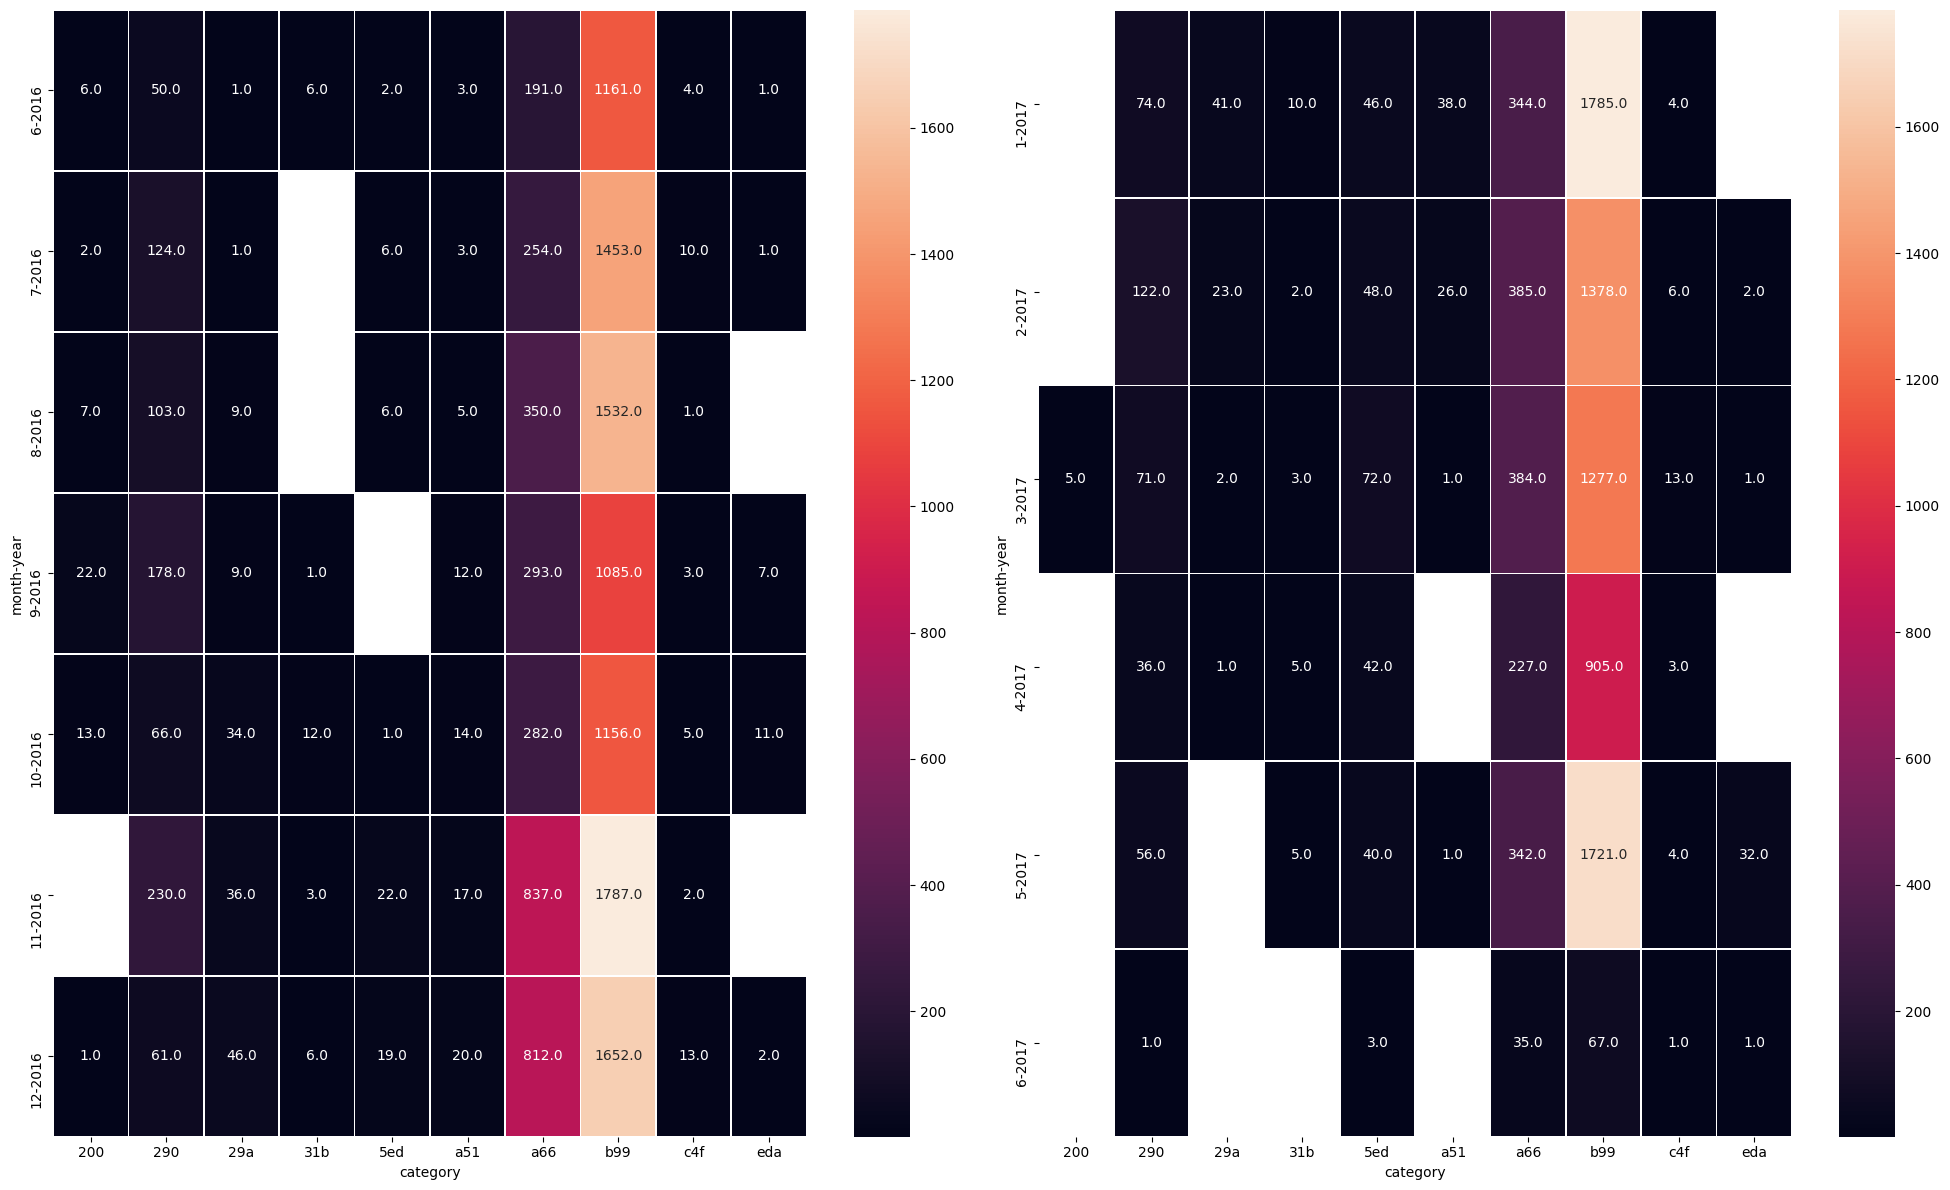

In [23]:
## Compare 2016 x 2017 by category and quantity
df_analysis =  pd.read_csv('desafio.csv')

df_analysis['category'] = df_analysis['category'].map(lambda x: x[-3:])
df_analysis['source_channel'] = df_analysis['source_channel'].map(lambda x: x[-3:])
df_analysis['code'] = df_analysis['code'].map(lambda x: x[-3:])

df_analysis = df_analysis[df_analysis['category'] !='64b']

df_analysis['month'] = df_analysis['process_date'].map(lambda x: int(x.split('-')[1]))
# df['month'].value_counts()

df_analysis['year'] = df_analysis['process_date'].map(lambda x: int(x.split('-')[0]))
# df['year'].value_counts()

df_analysis = df_analysis[df_analysis['year'] !=0 ]

plt.figure(figsize=(20,12))
plt.subplot(1,2,1)
sum_crosstab = pd.pivot_table(
    df_analysis[df_analysis['year']==2016], values='quantity', index=['month', 'year'], columns=['category'], aggfunc=np.sum
)
sns.heatmap(sum_crosstab, linewidths=.5,  annot=True, fmt=".1f")
plt.subplot(1,2,2)
sum_crosstab = pd.pivot_table(
    df_analysis[df_analysis['year']==2017], values='quantity', index=['month', 'year'], columns=['category'], aggfunc=np.sum
)
sns.heatmap(sum_crosstab, linewidths=.5,  annot=True, fmt=".1f")
plt.tight_layout()
plt.show()

### MODEL  UNSUPERVISED TO DEFINE CLUSTERS USING PYCARET

Creating Clusters using the existing features from the data is an unsupervised ML technique to engineer and create new features. It uses iterative approach to determine the number of clusters using combination of Calinski-Harabasz and Silhouette criterion. Each data point with the original features is assigned to a cluster. The assigned cluster label is then used as a new feature in predicting target variable. This can be achieved in PyCaret using create_clusters parameter within setup.

https://pycaret.org/create-clusters/

In [24]:
# Creating the model to obtain the clusters
from pycaret.regression import *

desafio_data = setup(
    target = 'quantity',
    data = df,
    normalize=True,
    normalize_method="robust",
    pca = False,
    session_id=123,
    create_clusters = True,
    remove_outliers = True,
    use_gpu=True, 
)

,Description,Value
0,session_id,123
1,Target,quantity
2,Original Data,"(21397, 10)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(14228, 50)"


In [67]:
# Choose the dataset that represents the groups (OBS: Can have more than one)
for i in range(len(desafio_data)):
    if type(desafio_data[i])== pd.core.frame.DataFrame:
        d=i
        print(d)
        break

8


In [68]:
# 7 groups were found: data_cluster_0, data_cluster_1, data_cluster_2, data_cluster_4, data_cluster_5, data_cluster_6, data_cluster_7
desafio_data[d]

,price,pis_cofins,icms,tax_substitution,liquid_cost,code_2a0,code_2fb,code_cb3,code_cd1,code_e21,...,process_date_weekday_6,process_date_is_month_end_1,process_date_is_month_start_1,data_cluster_0,data_cluster_1,data_cluster_2,data_cluster_4,data_cluster_5,data_cluster_6,data_cluster_7
0,17.545454,11.187366,-0.871780,4.265194,423.199982,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18.817959,11.843238,4.149863,0.000000,423.199982,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17.545454,11.187366,-0.871780,4.265194,423.199982,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17.482258,11.154785,-0.871780,4.276108,423.199982,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,19.988911,12.446787,4.405769,0.000000,423.199982,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169658,1.026607,2.673133,0.261650,0.000000,-21.771004,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
169659,0.311308,2.304443,0.105325,0.000000,-21.771004,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
169660,0.474501,2.388557,-0.871780,0.865153,-21.771004,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
169661,0.845233,2.579641,0.222011,0.000000,-21.771004,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


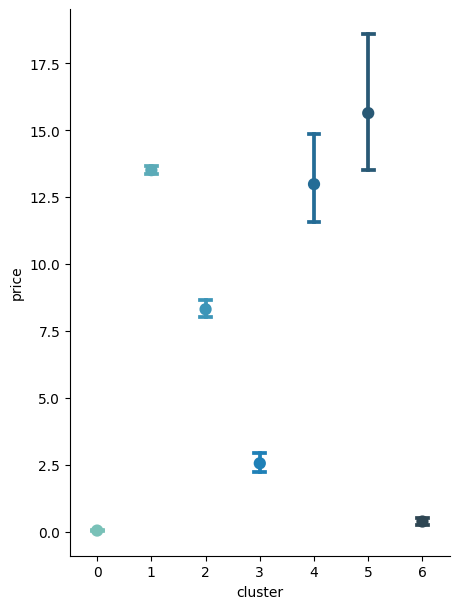

In [54]:
# EDA by cluster
import seaborn as sns
# https://seaborn.pydata.org/examples/index.html
# https://seaborn.pydata.org/generated/seaborn.catplot.html

df_cluster_0 = desafio_data[8][desafio_data[8]['data_cluster_0']== 1]
df_cluster_1 = desafio_data[8][desafio_data[8]['data_cluster_1']== 1]
df_cluster_2 = desafio_data[8][desafio_data[8]['data_cluster_2']== 1]
df_cluster_3 = desafio_data[8][desafio_data[8]['data_cluster_4']== 1]
df_cluster_4 = desafio_data[8][desafio_data[8]['data_cluster_5']== 1]
df_cluster_5 = desafio_data[8][desafio_data[8]['data_cluster_6']== 1]
df_cluster_6 = desafio_data[8][desafio_data[8]['data_cluster_7']== 1]

df_prices_by_cluster = pd.DataFrame({
    "cluster": [0] * df_cluster_0.shape[0] + [1] * df_cluster_1.shape[0] + [2] * df_cluster_2.shape[0] + [3] * df_cluster_3.shape[0] + [4] * df_cluster_4.shape[0] + [5] * df_cluster_5.shape[0] + [6] * df_cluster_6.shape[0],
    "price": list(df_cluster_0['price']) + list(df_cluster_1['price']) + list(df_cluster_2['price']) + list(df_cluster_3['price'])+ list(df_cluster_4['price']) + list(df_cluster_5['price']) + list(df_cluster_6['price'])
})


sns.catplot(x="cluster", y="price", capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=df_prices_by_cluster)
plt.show()

In [55]:
# EDA by cluster
df_cluster_0.describe()

,price,pis_cofins,icms,tax_substitution,liquid_cost,code_2a0,code_2fb,code_cb3,code_cd1,code_e21,...,process_date_weekday_6,process_date_is_month_end_1,process_date_is_month_start_1,data_cluster_0,data_cluster_1,data_cluster_2,data_cluster_4,data_cluster_5,data_cluster_6,data_cluster_7
count,15488.000000,15488.000000,15488.000000,15488.000000,15488.000000,15488.0,15488.000000,15488.0,15488.000000,15488.0,...,15488.000000,15488.000000,15488.000000,15488.0,15488.0,15488.0,15488.0,15488.0,15488.0,15488.0
mean,0.066805,0.150458,-0.209403,0.330592,0.307139,0.0,0.047714,0.0,0.943892,0.0,...,0.086067,0.026666,0.033768,1.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.806864,0.639371,0.485757,0.484412,5.343489,0.0,0.213170,0.0,0.230132,0.0,...,0.280466,0.161105,0.180626,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-1.485809,0.000000,-0.871780,0.000000,-2.432297,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.392461,0.000000,-0.871780,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.0,...,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-0.150776,0.000000,0.000026,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.0,...,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.150776,0.000000,0.097486,1.031366,0.000000,0.0,0.000000,0.0,1.000000,0.0,...,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
max,6.658535,5.575972,1.909703,1.838503,79.802094,0.0,1.000000,0.0,1.000000,0.0,...,1.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
df_cluster_1.describe()

,price,pis_cofins,icms,tax_substitution,liquid_cost,code_2a0,code_2fb,code_cb3,code_cd1,code_e21,...,process_date_weekday_6,process_date_is_month_end_1,process_date_is_month_start_1,data_cluster_0,data_cluster_1,data_cluster_2,data_cluster_4,data_cluster_5,data_cluster_6,data_cluster_7
count,1069.000000,1069.000000,1069.000000,1069.000000,1069.000000,1069.0,1069.0,1069.0,1069.0,1069.0,...,1069.000000,1069.000000,1069.000000,1069.0,1069.0,1069.0,1069.0,1069.0,1069.0,1069.0
mean,13.518138,9.091439,1.292431,1.440558,376.289307,0.0,0.0,0.0,0.0,0.0,...,0.084191,0.023386,0.037418,0.0,1.0,0.0,0.0,0.0,0.0,0.0
std,2.505477,1.377637,2.119134,1.525692,4.932566,0.0,0.0,0.0,0.0,0.0,...,0.277803,0.151197,0.189873,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,10.450331,0.000000,-0.871780,0.000000,354.911011,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
25%,12.184033,8.423955,-0.871780,0.000000,377.423187,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50%,12.909088,8.797660,2.557157,0.000000,377.423187,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,14.241684,9.487597,3.227758,3.002759,377.423187,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
max,49.062077,27.431839,9.311544,3.595784,377.423187,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0


##### Assessing the quality of the grouping and how the characteristics define each group.

Three important factors by which clustering can be evaluated are:Clustering tendency, Number of clusters and Clustering quality

(a) Based on the graphs above we see that our dataset has a cluster tendency - Has non-uniform distribution

(b) The number of clusters is 7, this shows us a good separation, we know that our dataset has 10 categories

(c) Based on the intrinsic measure: We use the Calinski-Harabasz and Silhouette criterion model.


##### The characteristics that define each group are:

 - Despite other factors, the price and quantity  of the product is a factor that defines the groups



###### Source
https://towardsdatascience.com/clustering-evaluation-strategies-98a4006fcfc

##  Looking for the best regression algorithm

In [56]:
# Compare several models and see which is the best
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0046,0.0035,0.0542,0.9889,0.0000,0.0019,1.7430
gbr,Gradient Boosting Regressor,0.0078,0.0046,0.0655,0.9845,0.0000,0.0039,1.8460
rf,Random Forest Regressor,0.0056,0.0054,0.0664,0.9830,0.0000,0.0022,1.5300
xgboost,Extreme Gradient Boosting,0.0078,0.0107,0.0947,0.9648,0.0000,0.0033,2.5380
catboost,CatBoost Regressor,0.0081,0.0137,0.0839,0.9629,0.0000,0.0039,7.0830
dt,Decision Tree Regressor,0.0063,0.0123,0.0946,0.9623,0.0000,0.0023,0.0440
lr,Linear Regression,0.0914,0.0304,0.1732,0.8866,0.0000,0.0796,0.0280
ridge,Ridge Regression,0.0914,0.0304,0.1733,0.8866,0.0000,0.0797,0.0220
br,Bayesian Ridge,0.0914,0.0304,0.1732,0.8866,0.0000,0.0796,0.0450
omp,Orthogonal Matching Pursuit,0.0973,0.0402,0.1990,0.8510,0.0000,0.0819,0.0190


#### For me the best model is the one with the smallest MAPE(Mean Absolute Percentage Error) 

#### It measures the absolute size of each error in percentage terms and then calculates the average of all percentages.

#### Here we see the R2 that shows us the quality of our model R2 = 0.9889

In [81]:
# Create model based on et(Extra Trees Regressor)
et = create_model('et', fold=10, round=4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0040,0.0020,0.0449,0.9922,-0.0000,0.0014
1,0.0032,0.0020,0.0445,0.9920,-0.0000,0.0014
2,0.0026,0.0012,0.0349,0.9942,-0.0000,0.0011
3,0.0029,0.0009,0.0306,0.9957,-0.0000,0.0015
4,0.0074,0.0096,0.0980,0.9760,-0.0000,0.0020
5,0.0072,0.0094,0.0971,0.9756,-0.0000,0.0029
6,0.0039,0.0017,0.0411,0.9953,-0.0000,0.0017
7,0.0058,0.0031,0.0559,0.9888,-0.0000,0.0036
8,0.0028,0.0010,0.0313,0.9947,-0.0000,0.0011
9,0.0066,0.0041,0.0637,0.9844,-0.0000,0.0023


In [83]:
# Evaluating the model
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [84]:
# Evaluating the model
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [121]:
# Predict model
predict_model(et);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0172,0.1235,0.3514,0.7802,0.0376,0.0071


### Sales forecast for the months of June, July and August 2017

In [122]:
# Creates a dataset without Category 64b with the months June, July, August 2017 for Forecast.
df_prev_2017_no_64b = pd.read_csv('desafio.csv')

# simplify hash names 
df_prev_2017_no_64b['category'] = df_prev_2017_no_64b['category'].map(lambda x: x[-3:])
df_prev_2017_no_64b['source_channel'] = df_prev_2017_no_64b['source_channel'].map(lambda x: x[-3:])
df_prev_2017_no_64b['code'] = df_prev_2017_no_64b['code'].map(lambda x: x[-3:])

# Get just sucessfull sales
df_prev_2017_no_64b = df_prev_2017_no_64b[df_prev_2017_no_64b['process_status'] == 'processado']

# delete columns
columns_to_delete = [
    "order_id",
    "order_status",
    "capture_date",
    "process_status",
]
df_prev_2017_no_64b.drop(columns_to_delete, 1, inplace=True)

# Remove category 64b
df_prev_2017_no_64b = df_prev_2017_no_64b[df_prev_2017_no_64b['category'] !='64b'] # sem 64b

# Create data to 2017
df_prev_2017_no_64b['process_date'] = df_prev_2017_no_64b['process_date'].map(lambda x: x.replace('2016','2017'))

# transform datetime
df_prev_2017_no_64b = df_prev_2017_no_64b[df_prev_2017_no_64b['process_date']!='0000-00-00']
df_prev_2017_no_64b['process_date'] = pd.to_datetime(df_prev_2017_no_64b['process_date'], infer_datetime_format=True)

# criate de range 2017
df_prev_2017_no_64b_done = df_prev_2017_no_64b[(df_prev_2017_no_64b['process_date'] >= datetime.datetime.strptime('2017-06-01', "%Y-%m-%d")) & (df_prev_2017_no_64b['process_date'] <= datetime.datetime.strptime('2017-08-31', "%Y-%m-%d"))]

# Visualize
df_prev_2017_no_64b_done.head(2)

,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,process_date,source_channel
0,ad5,1,978.90,90.5483,0.0000,191.8416,31b,542.7065,2017-06-11,500
1,ad5,1,1036.29,95.8568,176.1693,0.0000,31b,542.7065,2017-06-11,500


In [123]:
# Apply the model with the new data
new_data = df_prev_2017_no_64b_done.sample(100).drop('quantity',1)
et_pred_new = predict_model(et, data = new_data)
et_pred_new['Label'].value_counts()

1.00     93
2.00      3
1.01      1
5.00      1
4.00      1
10.50     1
Name: Label, dtype: int64

In [124]:
# Prediction result
et_pred_new = predict_model(et, data = df_prev_2017_no_64b_done)
et_pred_new

,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,process_date,source_channel,Label
0,ad5,1,978.90,90.5483,0.0000,191.8416,31b,542.7065,2017-06-11,500,1.08
1,ad5,1,1036.29,95.8568,176.1693,0.0000,31b,542.7065,2017-06-11,500,1.07
2,ad5,1,978.90,90.5483,0.0000,191.8416,31b,542.7065,2017-06-12,500,1.08
4,ad5,1,976.05,90.2846,0.0000,192.3325,31b,542.7065,2017-06-13,500,1.08
5,ad5,1,1089.10,100.7418,185.1470,0.0000,31b,542.7065,2017-06-13,002,1.08
...,...,...,...,...,...,...,...,...,...,...,...
167445,02a,1,42.64,3.9442,7.2488,0.0000,eda,42.9090,2017-06-01,bb9,1.00
169635,29e,1,209.00,19.3325,35.5300,0.0000,5ed,97.7355,2017-06-16,500,1.00
169636,29e,1,213.90,19.7858,0.0000,38.6122,5ed,97.7355,2017-06-22,500,1.00
169637,29e,1,231.29,21.3943,41.6322,0.0000,5ed,97.7355,2017-08-28,500,1.00


In [125]:
## Better prediction look
# Label = Amount predicted by the algorithm
et_pred_new_64 = pd.DataFrame(et_pred_new_64)
et_pred_new_64['month'] = et_pred_new_64['process_date'].map(lambda x: x.month)
et_pred_new_64['year'] = et_pred_new_64['process_date'].map(lambda x: x.year)
et_pred_new_64[['month','year','Label', 'code']][et_pred_new_64['year']==2017].groupby(['month', 'year', 'code']).sum()
et_pred_new = pd.DataFrame(et_pred_new)
et_pred_new['month'] = et_pred_new['process_date'].map(lambda x: x.month)
et_pred_new['year'] = et_pred_new['process_date'].map(lambda x: x.year)
et_pred_new[['month','year','Label', 'code']][et_pred_new['year']==2017].groupby(['month', 'year', 'code']).sum()

Label
month year code         
6     2017 02a      2.00
           094      1.00
           1f1     21.04
           29e      3.00
           2a0     53.00
           2fb     18.08
           554      1.00
           5a9      1.70
           812      2.06
           83e      3.00
           ac5     51.54
           ad5      6.47
           c8c      4.00
           cb3     37.00
           cd1   1173.69
           e21      5.00
           e57    142.38
           fab      6.30
7     2017 02a      1.00
           094      2.02
           0f6      1.33
           1f1     25.00
           2a0     42.21
           2fb     22.38
           4e5      1.00
           554      1.00
           5a9     20.13
           812      6.06
           83e      3.04
           ac5    123.31
           c8c      7.00
           cb3     44.29
           cd1   1405.27
           e57    151.74
           fab      1.02
8     2017 1f1     19.00
           29e      1.00
           2a0     53.00
           2fb     86.97
           554      9.00
           5a9      5.44
           812      5.06
           83e      5.00
           ac5    102.81
           c8c      1.00
           cb3     72.92
           cd1   1477.63
           e21     10.02
           e57    149.43
           fab      7.31

### Reprocessing to category 64b

In [126]:
# Creates a dataset with Category 64b
df_prev_2017_64b = pd.read_csv('desafio.csv')

# simplify hash names 
df_prev_2017_64b['category'] = df_prev_2017_64b['category'].map(lambda x: x[-3:])
df_prev_2017_64b['source_channel'] = df_prev_2017_64b['source_channel'].map(lambda x: x[-3:])
df_prev_2017_64b['code'] = df_prev_2017_64b['code'].map(lambda x: x[-3:])

# Get just sucessfull sales
df_prev_2017_64b = df_prev_2017_64b[df_prev_2017_64b['process_status'] == 'processado']

# delete columns
columns_to_delete = [
    "order_id",
    "order_status",
    "capture_date",
    "process_status",
]
df_prev_2017_64b.drop(columns_to_delete, 1, inplace=True)

# Select only category 64b
df_prev_2017_64b = df_prev_2017_64b[df_prev_2017_64b['category'] =='64b'] 

# transform datetime
df_prev_2017_64b = df_prev_2017_64b[df_prev_2017_64b['process_date']!='0000-00-00']
df_prev_2017_64b['process_date'] = pd.to_datetime(df_prev_2017_64b['process_date'], infer_datetime_format=True)

# Visualize
df_prev_2017_64b.head(2)

,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,process_date,source_channel
356,4f9,1,404.91,37.4542,35.6329,0.0,64b,289.3563,2016-06-09,500
357,4f9,1,464.40,42.9570,54.4881,0.0,64b,289.3563,2016-06-08,500


In [127]:
from pycaret.regression import *

desafio_data = setup(
    target = 'quantity',
    data = df_prev_2017_64b,
    normalize=True,
    normalize_method="robust",
    pca = False,
    session_id=123,
    create_clusters = True,
    remove_outliers = True,
    use_gpu=True, 
)

,Description,Value
0,session_id,123
1,Target,quantity
2,Original Data,"(133044, 10)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(88474, 117)"


In [128]:
for i in range(len(desafio_data)):
    if type(desafio_data[i])== pd.core.frame.DataFrame:
        d=i
        print(d)
        break      

8


In [129]:
# 3 groups were found: data_cluster_0	data_cluster_1	data_cluster_2
desafio_data[d]

,price,pis_cofins,icms,tax_substitution,liquid_cost,code_02d,code_087,code_0a0,code_0c8,code_0de,...,process_date_weekday_2,process_date_weekday_3,process_date_weekday_4,process_date_weekday_5,process_date_weekday_6,process_date_is_month_end_0,process_date_is_month_start_1,data_cluster_0,data_cluster_1,data_cluster_2
356,1.174343,1.174344,0.462632,0.0,1.329277,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
357,1.514286,1.514286,0.928379,0.0,1.329277,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
358,1.174343,1.174344,0.462632,0.0,1.329277,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
359,1.431429,1.431432,0.886355,0.0,1.329277,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
360,1.431314,1.431314,-0.417545,0.0,1.329277,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179144,3.953200,3.953198,3.324834,0.0,0.788654,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
179145,1.428571,1.428571,1.580588,0.0,0.788654,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
179146,1.759314,1.759314,1.837935,0.0,0.788654,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
179147,1.414286,1.414289,1.459082,0.0,0.788654,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


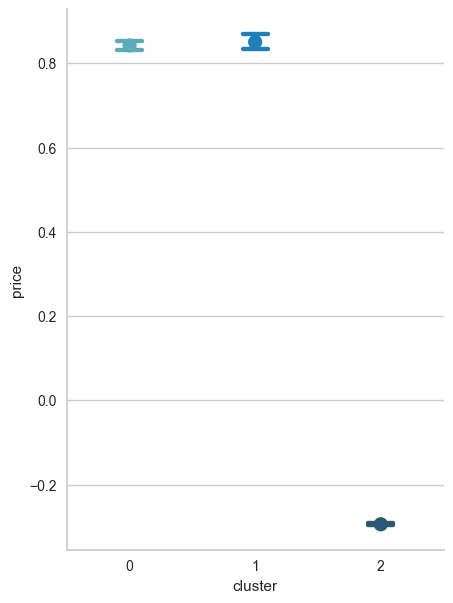

In [131]:
# EDA por cluster
import seaborn as sns
# https://seaborn.pydata.org/examples/index.html

df_cluster_0 = desafio_data[8][desafio_data[8]['data_cluster_0']== 1]
df_cluster_1 = desafio_data[8][desafio_data[8]['data_cluster_1']== 1]
df_cluster_2 = desafio_data[8][desafio_data[8]['data_cluster_2']== 1]

df_prices_by_cluster = pd.DataFrame({
    "cluster": [0] * df_cluster_0.shape[0] + [1] * df_cluster_1.shape[0] + [2] * df_cluster_2.shape[0],
    "price": list(df_cluster_0['price']) + list(df_cluster_1['price']) + list(df_cluster_2['price'])
})


sns.catplot(x="cluster", y="price", capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=df_prices_by_cluster)
plt.show()

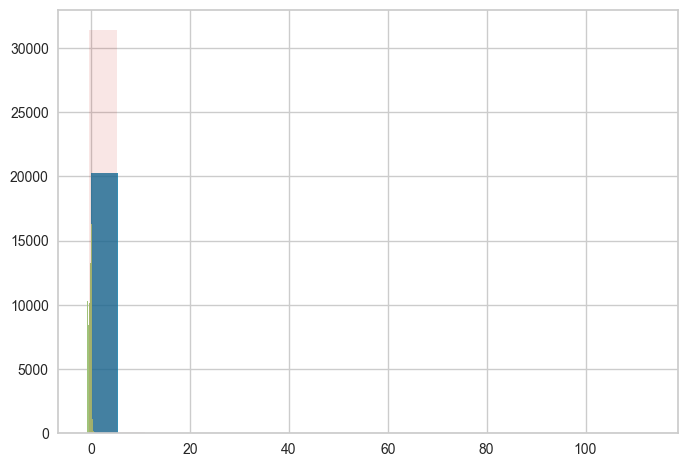

In [159]:
# EDA by cluster
df_cluster_1['price'].hist(bins=20, alpha=0.80)
df_cluster_2['price'].hist(bins=20, alpha=0.99)
df_cluster_0['price'].hist(bins=20, alpha=0.10)

plt.show()

In [160]:
df_cluster_0.describe()

,price,pis_cofins,icms,tax_substitution,liquid_cost,code_02d,code_087,code_0a0,code_0c8,code_0de,...,process_date_weekday_2,process_date_weekday_3,process_date_weekday_4,process_date_weekday_5,process_date_weekday_6,process_date_is_month_end_0,process_date_is_month_start_1,data_cluster_0,data_cluster_1,data_cluster_2
count,31494.000000,31494.000000,31494.000000,31494.000000,31494.000000,31494.000000,31494.000000,31494.000000,31494.000000,31494.000000,...,31494.000000,31494.000000,31494.000000,31494.000000,31494.000000,31494.000000,31494.000000,31494.0,31494.0,31494.0
mean,0.842489,0.838943,1.104963,0.000277,0.693810,0.000064,0.007049,0.004160,0.000064,0.000445,...,0.160189,0.163237,0.168635,0.118118,0.083667,0.974884,0.026545,1.0,0.0,0.0
std,0.987767,0.981597,0.773568,0.011217,0.240510,0.007969,0.083657,0.064351,0.007969,0.021076,...,0.366777,0.369578,0.374381,0.322731,0.276894,0.156459,0.160783,0.0,0.0,0.0
min,-0.428000,-1.139428,-0.417545,0.000000,-0.687557,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
25%,0.574286,0.574289,0.911128,0.000000,0.687017,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.0,0.0
50%,0.748571,0.747886,1.049264,0.000000,0.745031,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.0,0.0
75%,0.936914,0.935859,1.201770,0.000000,0.788654,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.0,0.0
max,113.106285,113.106285,88.475792,0.610340,1.329277,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.0,0.0


### Evaluating the best model for 64b

In [161]:
# Best model
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0053,0.0065,0.0741,0.9485,0.0170,0.0026,23.4160
et,Extra Trees Regressor,0.0049,0.0083,0.0776,0.9404,0.0159,0.0023,40.9540
gbr,Gradient Boosting Regressor,0.0159,0.0079,0.0875,0.9269,0.0254,0.0109,23.5720
lightgbm,Light Gradient Boosting Machine,0.0101,0.0134,0.1052,0.8942,0.0214,0.0053,0.7240
dt,Decision Tree Regressor,0.0053,0.0127,0.1050,0.8905,0.0235,0.0024,0.8040
xgboost,Extreme Gradient Boosting,0.0114,0.0146,0.1121,0.8792,0.0235,0.0064,8.1080
catboost,CatBoost Regressor,0.0248,0.0269,0.1572,0.7678,0.0399,0.0160,18.4980
knn,K Neighbors Regressor,0.0211,0.0397,0.1924,0.6514,0.0513,0.0096,18.1020
ada,AdaBoost Regressor,0.1166,0.0468,0.2142,0.5560,0.0776,0.1031,14.3260
lr,Linear Regression,0.0925,0.0504,0.2204,0.5403,0.0668,0.0808,0.4250


In [162]:
# Create model based on et(Extra Trees Regressor)
et = create_model('et', fold=10, round=4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0044,0.0025,0.0496,0.9754,0.0140,0.0023
1,0.0046,0.0025,0.0499,0.9689,0.0148,0.0025
2,0.0047,0.0026,0.0507,0.9693,0.0172,0.0027
3,0.0045,0.0035,0.0590,0.9576,0.0158,0.0023
4,0.0058,0.0302,0.1739,0.8216,0.0160,0.0020
5,0.0076,0.0298,0.1726,0.8404,0.0195,0.0025
6,0.0042,0.0025,0.0500,0.9702,0.0151,0.0021
7,0.0047,0.0049,0.0699,0.9579,0.0158,0.0021
8,0.0042,0.0021,0.0460,0.9748,0.0158,0.0026
9,0.0046,0.0029,0.0539,0.9678,0.0147,0.0023


In [163]:
# Evaluating the model
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [164]:
# Predict model
predict_model(et);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0106,0.1001,0.3163,0.6365,0.0257,0.0034


### Sales forecast for the months of June, July and August 2017

In [165]:
import datetime
# Creates a dataset with Category 64b - Months : June, July, August 2017 for Forecast.
df_prev_2017_64b = pd.read_csv('desafio.csv')

# simplify hash names 
df_prev_2017_64b['category'] = df_prev_2017_64b['category'].map(lambda x: x[-3:])
df_prev_2017_64b['source_channel'] = df_prev_2017_64b['source_channel'].map(lambda x: x[-3:])
df_prev_2017_64b['code'] = df_prev_2017_64b['code'].map(lambda x: x[-3:])

# Get just sucessfull sales
df_prev_2017_64b = df_prev_2017_64b[df_prev_2017_64b['process_status'] == 'processado']

# delete columns
columns_to_delete = [
    "order_id",
    "order_status",
    "capture_date",
    "process_status",
]
df_prev_2017_64b.drop(columns_to_delete, 1, inplace=True)

# Select only category 64b
df_prev_2017_64b = df_prev_2017_64b[df_prev_2017_64b['category'] =='64b'] 

# Create data to 2017
df_prev_2017_64b['process_date'] = df_prev_2017_64b['process_date'].map(lambda x: x.replace('2016','2017'))

# transform datetime
df_prev_2017_64b = df_prev_2017_64b[df_prev_2017_64b['process_date']!='0000-00-00']
df_prev_2017_64b['process_date'] = pd.to_datetime(df_prev_2017_64b['process_date'], infer_datetime_format=True)

# criate de range
df_prev_2017_64b_done = df_prev_2017_64b[(df_prev_2017_64b['process_date'] >= datetime.datetime.strptime('2017-06-01', "%Y-%m-%d")) & (df_prev_2017_64b['process_date'] <= datetime.datetime.strptime('2017-08-31', "%Y-%m-%d"))]

# Visualize
df_prev_2017_64b_done.head(2)


,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,process_date,source_channel
356,4f9,1,404.91,37.4542,35.6329,0.0,64b,289.3563,2017-06-09,500
357,4f9,1,464.40,42.9570,54.4881,0.0,64b,289.3563,2017-06-08,500


In [166]:
# Apply the model with the new data
new_data_64 = df_prev_2017_64b_done.sample(100).drop('quantity',1)
et_pred_new_64 = predict_model(et, data = new_data_64)
et_pred_new_64['Label'].value_counts()

1.00    93
2.00     3
1.01     1
1.84     1
1.06     1
2.03     1
Name: Label, dtype: int64

In [167]:
# Prediction result
et_pred_new_64 = predict_model(et, data = df_prev_2017_64b_done)
et_pred_new_64

,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,process_date,source_channel,Label
356,4f9,1,404.91,37.4542,35.6329,0.0,64b,289.3563,2017-06-09,500,1.0
357,4f9,1,464.40,42.9570,54.4881,0.0,64b,289.3563,2017-06-08,500,1.0
358,4f9,1,404.91,37.4542,35.6329,0.0,64b,289.3563,2017-06-10,500,1.0
359,4f9,1,449.90,41.6158,52.7868,0.0,64b,289.3563,2017-06-08,f58,1.0
360,4f9,1,449.88,41.6139,0.0000,0.0,64b,289.3563,2017-06-08,5ee,1.0
...,...,...,...,...,...,...,...,...,...,...,...
178650,1a4,1,419.40,38.7945,71.2980,0.0,64b,219.1066,2017-08-31,500,1.0
178651,1a4,1,409.40,37.8695,73.6920,0.0,64b,219.1066,2017-08-31,500,1.0
178653,1a4,1,450.72,41.6916,81.1296,0.0,64b,219.1066,2017-08-31,5ee,1.0
179147,1a4,1,446.90,41.3383,75.9730,0.0,64b,219.1066,2017-06-01,500,1.0


In [168]:
#Better prediction look
# Label = Amount predicted by the algorithm
et_pred_new_64 = pd.DataFrame(et_pred_new_64)
et_pred_new_64['month'] = et_pred_new_64['process_date'].map(lambda x: x.month)
et_pred_new_64['year'] = et_pred_new_64['process_date'].map(lambda x: x.year)
et_pred_new_64[['month','year','Label', 'code']][et_pred_new_64['year']==2017].groupby(['month', 'year', 'code']).sum()

Label
month year code        
6     2017 02d   129.18
           047    54.78
           06c    10.00
           087     3.00
           0a0    23.14
...                 ...
8     2017 e6f    40.00
           e94     1.00
           eee    20.00
           f58   114.30
           fc3    41.99

[246 rows x 1 columns]

### Conclusion and analysis of results


##### Considerando a quantidade de dados fornecidos, o resultado foi satisfatório. Mas para um melhor resultado seria necessário mais dados, pois apenas com um mês de referência (YTD) fica difícil prever o comportamento das vendas do ano seguinte. Sendo assim, seria melhor ter mais dados de um mesmo mês ao longo dos anos para fazer outras análises, como por exemplo Séries Temporais.  

##### Há o viés da quantidade de produtos de uma única categoria representando 87% do dataset. Então, optei por dividir em 2 conjuntos de dados, mas poderia usar outra solução, tal como: métodos para lidar com dados desbalanceados, tipo Smote ou Engenharia de features.

##### Foi visto também que  97% dos pedidos eram de apenas 1 item por order_id, isso também precisa de uma atenção, pois o algoritmo pode estar ruim e ainda assim acertar mais de 90% das vezes, impactando muito a gestão de estoque.

##### Outra percepção é em relação ao source_channel e os produtos ou categorias, pelo nome pensa-se que deve ser os canais de vendas, se assim for, provavelmente o channel com final 500 deve ser o site ou app. Seria uma análise muito bacana com o time de marketing para saber se tal produto ou categoria vendeu mais ou se deslocou de um souce para outro após uma determinada campanha.

##### Sobre o process_status, considerei que só era relevante quando o status fosse processado, entendendo que o produto só sai do estoque se a venda for concluída com sucesso, porque no caso do status captado vê-se muito pedido cancelado, boleto não pago, fraude e outros. Não tenho a informação se o pedido captado remove virtualmente o produto temporariamente do estoque, sendo assim, com  conhecimento desse fato seria importante uma melhor análise dos produtos captados. 